In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
%matplotlib inline

In [ ]:
pretrained_bert_large = BertModel.from_pretrained("bert-large-uncased")

In [ ]:
print(pretrained_bert_large)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
tokenizer_bert_large = BertTokenizer.from_pretrained("bert-large-uncased")

In [ ]:
print(tokenizer_bert_large.vocab.keys())

odict_keys(['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused7

In [ ]:
print(len(tokenizer_bert_large.vocab.keys()))

30522


In [ ]:
with open("vocabulary.txt", 'w') as f:
    for token in tokenizer_bert_large.vocab.keys():
        f.write(token + '\n')

Let's first look at how BERT embedds similar sentences. For this we will take the paraphrase dataset https://storage.googleapis.com/paws/english/paws_wiki_labeled_final.tar.gz from here and look at the distace between two sentences that are similar in meaning, but are phrased differently.

In [ ]:
%mkdir paraphrase_data
%cd paraphrase_data
! wget https://storage.googleapis.com/paws/english/paws_wiki_labeled_final.tar.gz
!tar -xf paws_wiki_labeled_final.tar.gz
%mv final/* ./
%rmdir final
% cd ../
%ls 

mkdir: cannot create directory ‘paraphrase_data’: File exists
/content/paraphrase_data
--2020-07-06 09:44:38--  https://storage.googleapis.com/paws/english/paws_wiki_labeled_final.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 74.125.130.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4687157 (4.5M) [application/gzip]
Saving to: ‘paws_wiki_labeled_final.tar.gz’

paws_wiki_labeled_f 100%[===================>]   4.47M  --.-KB/s    in 0.03s   

2020-07-06 09:44:38 (135 MB/s) - ‘paws_wiki_labeled_final.tar.gz’ saved [4687157/4687157]

/content
common_words/    paraphrase_data/                test.tsv
dev.tsv          paws_wiki_labeled_final.tar.gz  train.tsv
first-names.txt  sample_data/                    vocabulary.txt


In [ ]:
import pandas as pd

similar_sentences = pd.read_csv("paraphrase_data/train.tsv", sep='\t')
similar_sentences.head()

,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1


In [ ]:
similar_sentences.describe()

,id,label
count,49401.000000,49401.000000
mean,24701.000000,0.441874
std,14260.984661,0.496615
min,1.000000,0.000000
25%,12351.000000,0.000000
50%,24701.000000,0.000000
75%,37051.000000,1.000000
max,49401.000000,1.000000


Each label has two possible values: 0 indicates the pair has different meaning, while 1 indicates the pair is a paraphrase. We only need sentences that have the same meaning, so we will drop all the 0 labels. 

In [ ]:
# similar_sentences = similar_sentences[similar_sentences.label != 0]
similar_sentences.tail()

,id,sentence1,sentence2,label
49396,49397,"`` Our school is of spiritual and spiritual , ...",`` Our School is of the Temporal and the Spiri...,0
49397,49398,She was in Cork on June 24 and arrived on 8 Ju...,"She was at Cork on 24 June , and arrived in th...",1
49398,49399,Cornelia Stuyvesant Vanderbilt ( George and Ed...,John John F. A. Cecil ( the only child of Geor...,0
49399,49400,The third season was premiered on 7 June 2010 ...,"The fourth season was premiered on June 7 , 20...",0
49400,49401,It is also from a location on the mainland Los...,It is also known from one location on the main...,0


Let's first look at 2 pairs, one easier and one harder to detect similarity.

In [ ]:
for index, rows in similar_sentences.head(2).iterrows(): 
    one_sentence_pair_easy =[rows.sentence1, rows.sentence2]  
  
for index, rows in similar_sentences.head(3).iterrows(): 
    one_sentence_pair_hard =[rows.sentence1, rows.sentence2]  
  
print(one_sentence_pair_easy) 
print(one_sentence_pair_hard)

pairs = [one_sentence_pair_easy, one_sentence_pair_hard]


['The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .', 'The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .']
['There are also specific discussions , public profile debates and project discussions .', 'There are also public discussions , profile specific discussions , and project discussions .']


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained("bert-large-uncased",
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


embedding_pairs = []
for pair in pairs:
  embedding_pair = {}
  for sentance in pair:
    marked_text = "[CLS] " + sentance + " [SEP]"

    tokenized_text = tokenizer_bert_large.tokenize(marked_text)
    indexed_tokens = tokenizer_bert_large.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

      # token_embeddings = torch.stack(hidden_states, dim=0)
      # token_embeddings = torch.squeeze(token_embeddings, dim=1)

      token_vecs = hidden_states[-2][0]
      sentence_embedding = torch.mean(token_vecs, dim=0)
      embedding_pair[sentance] = sentence_embedding

      # print(sentence_embedding)
  embedding_pairs.append(embedding_pair)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(embedding_pairs)

[{'The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .': tensor([-0.6364, -0.0912, -0.0987,  ..., -0.0654, -0.2911,  0.1526]),
  'The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .': tensor([-0.5528, -0.1065, -0.1094,  ..., -0.0698, -0.2392,  0.2039])},
 {'There are also public discussions , profile specific discussions , and project discussions .': tensor([-0.0136, -0.1087, -0.4273,  ..., -0.2754, -0.1618,  0.3664]),
  'There are also specific discussions , public profile debates and project discussions .': tensor([-0.0167, -0.1890, -0.3151,  ..., -0.4174, -0.2867,  0.6388])}]


In [ ]:
from scipy.spatial.distance import cosine

differences = []

for pair_index in range(len(pairs)):
  diff = 1 - cosine(embedding_pairs[pair_index][pairs[pair_index][0]], embedding_pairs[pair_index][pairs[pair_index][1]])
  differences.append(diff)
  print(pairs[pair_index], diff)



['The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .', 'The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .'] 0.9903557300567627
['There are also specific discussions , public profile debates and project discussions .', 'There are also public discussions , profile specific discussions , and project discussions .'] 0.9772712588310242


Let's do the same thing on more samples

In [ ]:
from statistics import mean 

pairs = similar_sentences[["sentence1", "sentence2"]].head(100).values.tolist()

embedding_pairs = []
for pair in pairs:
  embedding_pair = {}
  for sentance in pair:
    marked_text = "[CLS] " + sentance + " [SEP]"

    tokenized_text = tokenizer_bert_large.tokenize(marked_text)
    indexed_tokens = tokenizer_bert_large.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

      token_vecs = hidden_states[-2][0]
      sentence_embedding = torch.mean(token_vecs, dim=0)
      embedding_pair[sentance] = sentence_embedding

  embedding_pairs.append(embedding_pair)

differences = []

for pair_index in range(len(pairs)):
  diff = 1 - cosine(embedding_pairs[pair_index][pairs[pair_index][0]], embedding_pairs[pair_index][pairs[pair_index][1]])
  differences.append(diff)

print("Mean cosine difference score between 100 similar sentence pairs", mean(differences))

Mean cosine difference score between 100 similar sentence pairs 0.9910045844316483


Now Let's look at the top 10000 words and see which of those are in BERT vocabulary and which aren't.
We will download the words from here https://github.com/first20hours/google-10000-english/blob/master/google-10000-english-usa.txt
The frequenсy of the words is determined by n-gram frequency analysis of the Google's Trillion Word Corpus.

In [ ]:
%mkdir common_words
%cd common_words
! git clone https://github.com/first20hours/google-10000-english
%mv google-10000-english/google-10000-english-usa.txt ./
% rm -rf google-10000-english
% cd ../
%ls common_words

/content/common_words
Cloning into 'google-10000-english'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (87/87), done.
/content
google-10000-english-usa.txt


In [ ]:
common_words = open("common_words/google-10000-english-usa.txt",'r').read().split('\n')
common_words[:10]

['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']

In [ ]:
bert_vocab = list(tokenizer_bert_large.vocab.keys())
bert_vocab[10000:10010]

['raven',
 'travis',
 'classics',
 'proven',
 'voltage',
 'pillow',
 'fists',
 'butt',
 '1842',
 'interpreted']

Words that are in top 10000 most frequent words, but aren't in BERT vocab

In [ ]:
print(list(set(common_words) - set(bert_vocab)))
print("the amount of words that are not in bert vocab: ", len(list(set(common_words) - set(bert_vocab))))

['blogging', 'bg', 'disclaimer', 'accessing', 'quotations', 'listprice', 'formatting', 'aud', 'exec', 'beastality', 'paperbacks', 'intranet', 'msg', 'misc', 'advert', 'masturbation', 'collectibles', 'alerts', 'faqs', 'resumes', 'refinance', 'snowboard', 'df', 'ooo', 'bw', 'const', 'treo', 'sexo', 'optimize', 'printable', 'symantec', 'cursor', 'latinas', 'adidas', 'waterproof', 'viagra', 'url', 'hereby', 'gamespot', 'wiki', 'yn', 'boob', 'rebates', 'bbw', 'aol', 'pci', 'temp', 'login', 'italic', 'devel', 'fax', 'asp', 'cingular', 'shemales', 'config', 'biol', 'lf', 'hydrocodone', 'workstation', 'beastiality', 'mortgages', 'ids', 'lite', 'inf', 'pda', 'pentium', 'moderators', 'tue', 'ln', 'pb', 'gratuit', 'slut', 'webcast', 'fs', 'router', 'hb', 'dx', 'telephony', 'complimentary', 'eval', 'newsletters', 'pgp', 'peeing', 'keyword', 'referrals', 'appraisal', 'conferencing', 'verizon', 'yr', 'adipex', 'forwarding', 'edt', 'suse', 'endif', 'pubmed', 'valium', 'italiano', 'realtor', 'fisting'

So, most of the common words are actually in BERT vocabulary. And the ones the aren't are beauties like: hydrocodone, beastiality, slut, handjob and others. 

Actually, let's look at swear words that are in bert vocab! I've seen a couple of butts and asses these aleready.

Here is a little list of swear words https://www.kaggle.com/nicapotato/bad-bad-words
You will have to upload it yourself

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving datasets_13808_18616_bad-words.csv to datasets_13808_18616_bad-words.csv


In [ ]:
import io
import functools
import operator

bad_words = pd.read_csv(io.BytesIO(uploaded['datasets_13808_18616_bad-words.csv']),sep=",",encoding="utf-8")
bad_words = bad_words.values.tolist()
bad_words = functools.reduce(operator.iconcat, bad_words, [])

In [ ]:
print(list(set(bad_words) & set(bert_vocab)))
print("The amount of 'bad' words in BERT vocab: ", len(list(set(bad_words) & set(bert_vocab))))

['sucks', 'devil', 'nigerian', 'doom', 'fu', 'rabbi', 'hostage', 'sperm', 'laid', 'mexican', 'kid', 'bitch', 'whiskey', 'pornography', 'tnt', 'erection', 'breast', 'primetime', 'burn', 'criminal', 'idiot', 'die', 'enemy', 'alla', 'erect', 'intercourse', 'abortion', 'dirty', 'pistol', 'nude', 'bombs', 'chin', 'german', 'failure', 'naked', 'drunk', 'spit', 'fight', 'jihad', 'asian', 'erotic', 'jewish', 'vomit', 'suck', 'slaughter', 'cocky', 'uk', 'girls', 'shit', 'penetration', 'virgin', 'terror', 'conservative', 'bullshit', 'domination', 'harder', 'soviet', 'lesbian', 'bisexual', 'africa', 'fungus', 'catholics', 'angry', 'execution', 'lies', 'penis', 'sex', 'allah', 'fairies', 'pee', 'dumb', 'latin', 'headlights', 'stroking', 'colored', 'asshole', 'corruption', 'hell', 'joint', 'dead', 'swallow', 'blacks', 'shooting', 'hardcore', 'nasty', 'lynch', 'fat', 'drug', 'prick', 'snatch', 'pissed', 'panties', 'explosion', 'chinese', 'faith', 'cocktail', 'tits', 'hiv', 'whore', 'brothel', 'sweet

Here, a lot of these words aren't bad at all, like: mexican, nigerian, german, kid, whiskey, breast, babies, abortion and others. 

However, we see words like: bitch, pornography, shit, bullshit, asshole, whore, rape, dick, butt, satan, fucked, heroin, cock, porn, hitler, cum, ass, pussy and fuck. 
These are all that I classify as like swear words from the list. So there is that)



In [ ]:
!pip install wget
import wget
import random 

print('Beginning file download with wget module')

url = 'http://www.gutenberg.org/files/3201/files/NAMES.TXT'
wget.download(url, 'first-names.txt')


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=af287a3044a57abd5abef650d605b1377388cf5ac535a71901844e620b168487
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Beginning file download with wget module


'first-names.txt'

In [ ]:
with open('first-names.txt', 'rb') as f:
    names_encoded = f.readlines()

names = []

for name in names_encoded:
    try:
        names.append(name.rstrip().lower().decode('utf-8'))
    except:
        continue
num_names = 0

for name in names:
    if name in tokenizer_bert_large.vocab.keys():
        num_names += 1

print('{:,} names in the vocabulary'.format(num_names))

3,869 names in the vocabulary


In [ ]:
# Count how many numbers are in the vocabulary.
count = 0

# For each token in the vocabulary...
for token in tokenizer_bert_large.vocab.keys():

    # Tally if it's a number.
    if token.isdigit():
        count += 1
        
        # Any numbers >= 10,000?
        if len(token) > 4:
            print(token)

print('BERT Vocab includes {:,} numbers.'.format(count))

BERT Vocab includes 881 numbers.


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained("bert-large-uncased",
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

top_10_words = ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']


for word in top_10_words:
  # marked_text = "[CLS] " + word + " [SEP]"

  tokenized_text = tokenizer_bert_large.tokenize(word)
  indexed_tokens = tokenizer_bert_large.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

    token_vecs = hidden_states[-2][0]
    word_embedding = torch.mean(token_vecs, dim=0)

    print(word, word_embedding)


the tensor([-1.4937, -0.9498, -0.3125,  ..., -0.0181,  1.8019,  1.3108])
of tensor([-1.6039, -0.1190, -0.3176,  ..., -0.0746,  0.9635,  0.5581])
and tensor([-1.1718, -0.4059, -0.7219,  ..., -0.2309,  1.1591,  0.0258])
to tensor([-1.3237,  0.1039, -0.3122,  ...,  0.5553,  1.2307,  0.4920])
a tensor([-1.8304, -1.0217, -0.4414,  ..., -0.0283,  0.9027,  0.5916])
in tensor([-1.9228, -0.8328, -0.2929,  ..., -0.3854,  0.7304,  0.6750])
for tensor([-0.6388,  0.3414, -1.4340,  ...,  1.3843,  0.6003, -0.9959])
is tensor([-1.6613, -1.2144, -0.4274,  ..., -0.3155,  1.5797,  1.1214])
on tensor([-0.4091,  0.1710,  0.0478,  ...,  0.0530,  0.6080, -0.2861])
that tensor([-2.0317, -0.6810, -0.5287,  ..., -0.1788,  0.6805,  0.5984])


In [ ]:
def bert_embeddings_plot(model, tokenizer, word_list):
  labels = []
  tokens = []

  for word in word_list:
    tokenized_text = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

      token_vecs = hidden_states[-2][0]
      word_embedding = torch.mean(token_vecs, dim=0)

      tokens.append(word_embedding.tolist())
      labels.append(word)
  
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
      
  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
  plt.show()


In [ ]:
print("Here is how BERT embedds top 100 words")
bert_embeddings_plot(model=model, tokenizer=tokenizer_bert_large, word_list=common_words[:500])

Let's see how BERT understands numbers. It has the 881 bumbers in it's corpus. Let's see their embeddings.

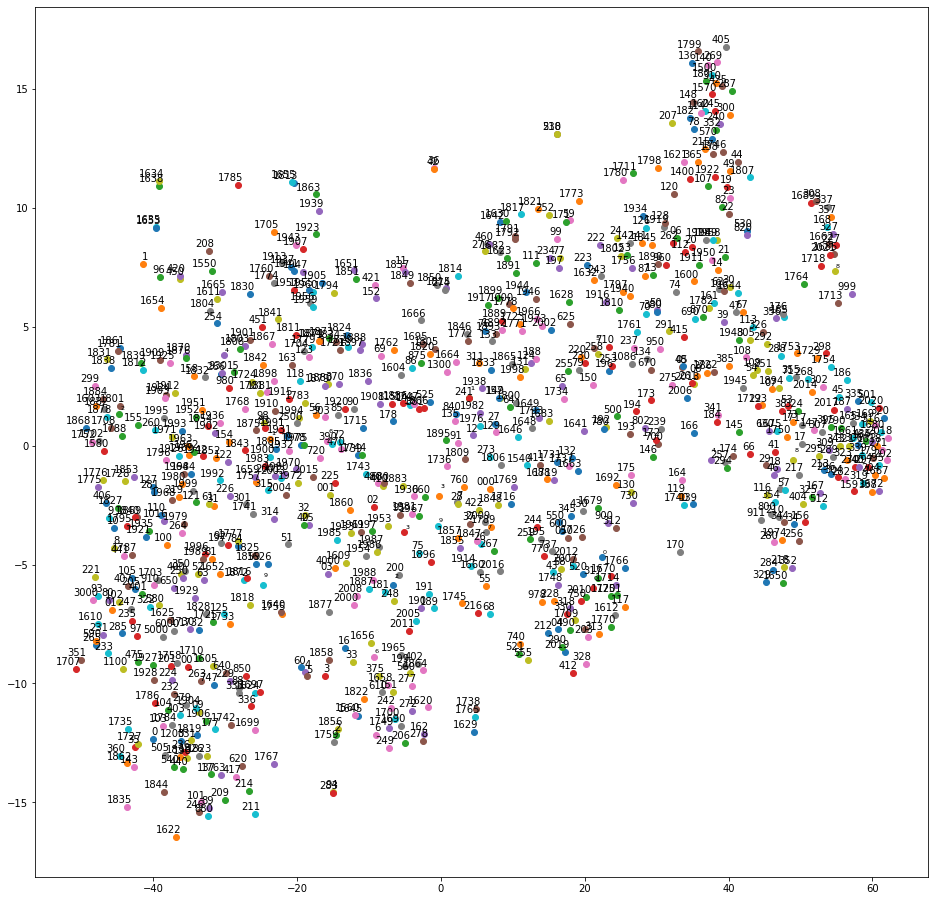

In [ ]:
numbers_in_bert_vocab = [token for token in tokenizer_bert_large.vocab.keys() if token.isdigit()]

bert_embeddings_plot(model=model, tokenizer=tokenizer_bert_large, word_list=numbers_in_bert_vocab)

I don't see logic here)

And just for fun - here are the swear words

In [ ]:
# swear_words = ["bitch", "pornography", "shit", "bullshit", "asshole", "whore", "rape", "dick", "butt", "satan", "fucked", "heroin", "cock", "porn", "hitler", "cum", "ass", "pussy", "fuck"]

# bert_embeddings_plot(model=model, tokenizer=tokenizer_bert_large, word_list=swear_words)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '²', '³', '¹', '⁰', '⁴', '⁵', '⁶', '⁷', '⁸', '⁹', '₀', '₁', '₂', '₃', '₄', '₅', '₆', '₇', '₈', '₉', '10', '000', '2010', '2011', '12', '2012', '2008', '2009', '2013', '2007', '2006', '2014', '15', '20', '18', '2015', '11', '2016', '30', '2005', '16', '14', '13', '2017', '25', '2004', '2000', '17', '24', '2003', '2002', '100', '21', '19', '2001', '22', '23', '1999', '28', '26', '27', '1998', '1997', '1996', '50', '29', '2018', '1995', '1994', '1992', '1993', '31', '40', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1980', '500', '1983', '1982', '1979', '1981', '200', '1972', '1976', '1978', '1974', '1975', '1977', '1970', '1968', '1973', '1945', '1971', '45', '60', '1969', '1967', '35', '65', '1964', '1966', '1965', '32', '1960', '1944', '1963', '1962', '1942', '80', '1961', '1943', '1956', '1958', '1959', '1941', '1940', '1948', '1957', '1939', '1946', '1950', '90', '33', '70', '1955', '300', '1952', '00', '1947', '4

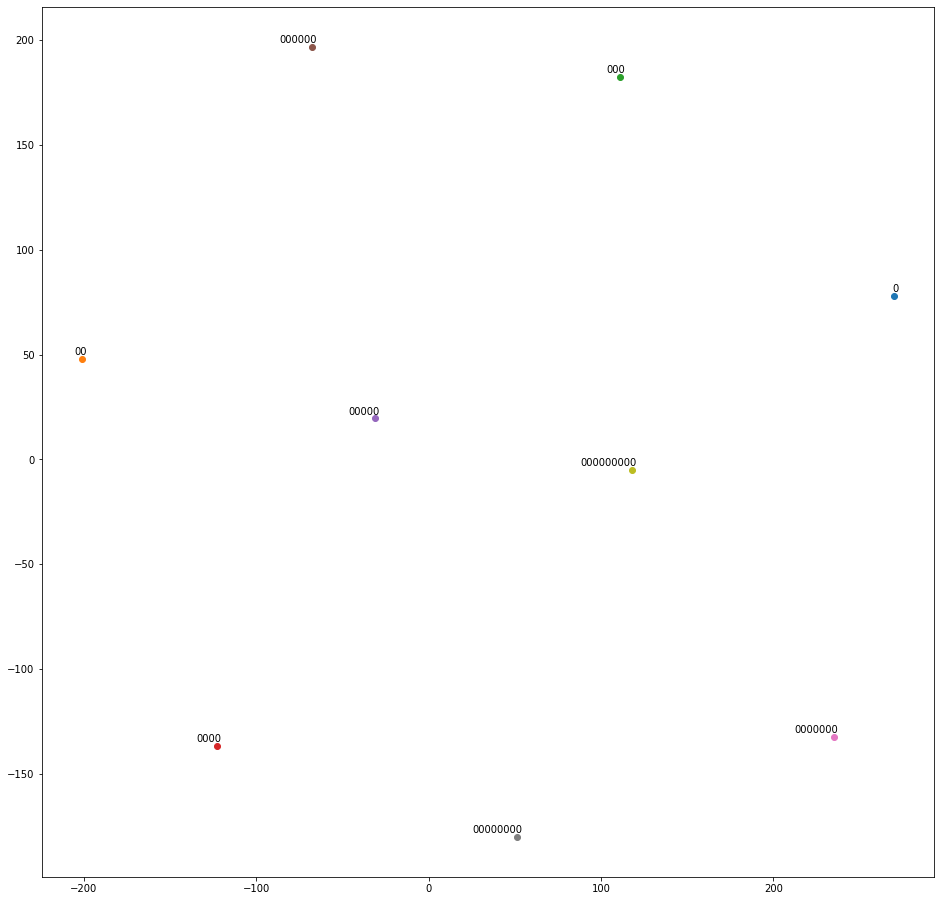

In [ ]:
print(numbers_in_bert_vocab)

print("Here is how BERT will treat a new number: ")

print(tokenizer_bert_large.tokenize('18901896700'))
print(tokenizer_bert_large.tokenize('9456189367'))
print(tokenizer_bert_large.tokenize('0000001000'))

print("Here is how BERT will treat floats: ")

print(tokenizer_bert_large.tokenize('3,14'))
print(tokenizer_bert_large.tokenize('2,718281'))

print("Here is how it will embedd a number 0")

zeros_list = ["0"*n for n in range(10)]
print(zeros_list)
bert_embeddings_plot(model=model, tokenizer=tokenizer_bert_large, word_list=zeros_list[1:])

In [ ]:
import itertools
from scipy.spatial.distance import cosine
from statistics import mean 


no_apples = ["I have {} apples".format("0"*n) for n in range(5)][1:]

no_apples = list(itertools.combinations(no_apples, 2))

# numbers_in_bert_vocab_pairs = [["5", n] for n in numbers_in_bert_vocab[:30]]
numbers_in_bert_vocab_pairs = list(itertools.combinations(numbers_in_bert_vocab[:-5], 2))
print(numbers_in_bert_vocab_pairs)

def bert_partwise_similarity(pairs, model, tokenizer):
  embedding_pairs = []
  for pair in pairs:
    embedding_pair = {}
    for sentance in pair:
      marked_text = "[CLS] " + sentance + " [SEP]"

      tokenized_text = tokenizer.tokenize(marked_text)
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [1] * len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])

      with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        embedding_pair[sentance] = sentence_embedding

    embedding_pairs.append(embedding_pair)

  differences = []

  for pair_index in range(len(pairs)):
    diff = 1 - cosine(embedding_pairs[pair_index][pairs[pair_index][0]], embedding_pairs[pair_index][pairs[pair_index][1]])
    print(pairs[pair_index], diff)
    differences.append(diff)
  return( mean(differences))


# print("Mean cosine difference score between same sentence pairs", bert_partwise_similarity(no_apples, model, tokenizer_bert_large))
print("Mean cosine difference score between number pairs", bert_partwise_similarity(numbers_in_bert_vocab_pairs, model, tokenizer_bert_large))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

